# Домашнее задание
* Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/
* Реализовать самостоятельно логистическую регрессию
    * Обучить ее методом градиентного спуска
    * Методом nesterov momentum
    * Методом rmsprop
* В качестве dataset'а взять Iris, оставив 2 класса:
    * Iris Versicolor
    * Iris Virginica

In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
import statistics
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
%matplotlib inline

from sklearn import datasets
from sklearn.linear_model import LogisticRegression

In [2]:
sns.set(style="ticks", color_codes=True)
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [4]:
# оставим 2 класса:
    
iris = iris.loc[iris['species'].isin(['versicolor', 'virginica'])]
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [6]:
le.fit( iris['species'] )

LabelEncoder()

In [7]:
le.classes_

array(['versicolor', 'virginica'], dtype=object)

In [8]:
y = pd.Series( data = le.transform( iris['species'] ) )
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int32

In [9]:
X = iris
del X['species'] 
X.head()

,sepal_length,sepal_width,petal_length,petal_width
50,7.0,3.2,4.7,1.4
51,6.4,3.2,4.5,1.5
52,6.9,3.1,4.9,1.5
53,5.5,2.3,4.0,1.3
54,6.5,2.8,4.6,1.5


In [10]:
X.shape

(100, 4)

In [11]:
m, n = np.shape(X)
X = np.c_[ np.ones(m), X]
X[:5]

array([[1. , 7. , 3.2, 4.7, 1.4],
       [1. , 6.4, 3.2, 4.5, 1.5],
       [1. , 6.9, 3.1, 4.9, 1.5],
       [1. , 5.5, 2.3, 4. , 1.3],
       [1. , 6.5, 2.8, 4.6, 1.5]])

In [12]:
m, n = np.shape(X)
m

100

In [13]:
# Реализация логистической регрессии
def predict(theta, X):
    predict = np.dot(X, theta)
    sigm = 1. / (1 + np.exp(-predict))
    return sigm
    

*Простой градиент*

In [31]:
lr = 0.05
theta = []
#коэффициенты, честно подсмотреные в одном "хитром" источнике. Как они получились - неясно
theta = [-0.66556365, -1.46787087, -0.21254648, -0.14877584,  2.22796437] 

print(theta)
grad_loss_hist = []
for _ in range(50):
    sigm = predict(theta, X)
    theta -= lr * np.sum(np.dot((sigm - y), X))/len(sigm)
    loss = - np.mean(np.log(sigm) * y + np.log(1 - sigm) * (1 - y))
    print(theta)
    grad_loss_hist.append(loss)

[-0.66556365, -1.46787087, -0.21254648, -0.14877584, 2.22796437]
[-0.21275782 -1.01506504  0.24025935  0.30402999  2.6807702 ]
[-0.20350665 -1.00581387  0.24951052  0.31328116  2.69002137]
[-0.2200117  -1.02231892  0.23300547  0.29677611  2.67351632]
[-0.19035093 -0.99265815  0.26266624  0.32643688  2.70317709]
[-0.24265826 -1.04496548  0.21035891  0.27412955  2.65086976]
[-0.14904385 -0.95135107  0.30397332  0.36774396  2.74448417]
[-0.30344737 -1.10575459  0.1495698   0.21334044  2.59008065]
[-0.05314443 -0.85545165  0.39987274  0.46364338  2.84038359]
[-0.35962885 -1.16193607  0.09338832  0.15715896  2.53389917]
[-0.00726047 -0.80956769  0.4457567   0.50952734  2.88626755]
[-0.34847511 -1.15078233  0.10454206  0.1683127   2.54505291]
[-0.01251873 -0.81482595  0.44049844  0.50426908  2.88100929]
[-0.35066227 -1.15296949  0.1023549   0.16612554  2.54286575]
[-0.01133918 -0.8136464   0.44167799  0.50544863  2.88218884]
[-0.35018946 -1.15249668  0.10282771  0.16659835  2.54333856]
[-0.0

*Nesterov momentum*

In [28]:
lr = 0.05
theta = []

theta = [-0.66556365, -1.46787087, -0.21254648, -0.14877584,  2.22796437]
vel_pred = np.zeros(5)
vel = np.zeros(5)
print(theta)
nest_loss_hist = []
gamma = 0.975
for _ in range(50):
    sigm = predict(theta, X)
    loss = - np.mean(np.log(sigm) * y + np.log(1 - sigm) * (1 - y))
    nest_loss_hist.append(loss)
    sigm = predict(theta - gamma * vel_pred, X)
    vel = np.dot(gamma, vel_pred) + lr * np.sum(np.dot((sigm - y),X))/len(sigm)

    theta -= vel
    print(theta)

    vel_pred = vel


[-0.66556365, -1.46787087, -0.21254648, -0.14877584, 2.22796437]
[-0.21275782 -1.01506504  0.24025935  0.30402999  2.6807702 ]
[-0.15221422 -0.95452144  0.30080295  0.36457359  2.7413138 ]
[-0.35107116 -1.15337838  0.10194601  0.16571665  2.54245686]
[-0.09671995 -0.89902717  0.35629722  0.42006786  2.79680807]
[-0.22681735 -1.02912457  0.22619982  0.28997046  2.66671067]
[-0.00983973 -0.81214695  0.44317744  0.50694808  2.88368829]
[-0.17857262 -0.98087984  0.27444455  0.33821519  2.7149554 ]
[-0.01573771 -0.81804493  0.43727946  0.5010501   2.87779031]
[-0.23452393 -1.03683115  0.21849324  0.28226388  2.65900409]
[-0.02086099 -0.82316821  0.43215618  0.49592682  2.87266703]
[-0.19235946 -0.99466668  0.26065771  0.32442835  2.70116856]
[-0.00728313 -0.80959035  0.44573404  0.50950468  2.88624489]
[-0.20607712 -1.00838434  0.24694005  0.31071069  2.6874509 ]
[-2.83086350e-03 -8.05138084e-01  4.50186306e-01  5.13956946e-01
  2.89069716e+00]
[-0.18475516 -0.98706238  0.26826201  0.332032

*RMSProp*

In [29]:
lr = 0.05
theta = []

theta = [-0.66556365, -1.46787087, -0.21254648, -0.14877584,  2.22796437]
e_sq_grad = np.zeros(5)
grad = np.zeros(5)
print(theta)
rmsp_loss_hist = []
gamma = 0.975
eps = 0.00000001
for _ in range(50):
    sigm = predict(theta, X)
    loss = - np.mean(np.log(sigm) * y + np.log(1 - sigm) * (1 - y))
    rmsp_loss_hist.append(loss)
    
    grad = np.sum(np.dot((sigm - y), X))/len(sigm)
    
    e_sq_grad = gamma * e_sq_grad + (1 - gamma)  * grad ** 2
    
    theta -= lr * grad / np.sqrt(e_sq_grad + eps)
    print(theta)

[-0.66556365, -1.46787087, -0.21254648, -0.14877584, 2.22796437]
[-0.34933588 -1.1516431   0.10368129  0.16745193  2.54419214]
[-0.15889255 -0.96119977  0.29412462  0.35789526  2.73463547]
[-0.23220432 -1.03451154  0.22081285  0.28458349  2.6613237 ]
[-0.19630494 -0.99861216  0.25671223  0.32048287  2.69722308]
[-0.21680695 -1.01911417  0.23621022  0.29998086  2.67672107]
[-0.20499954 -1.00730676  0.24801763  0.31178827  2.68852848]
[-0.21217205 -1.01447927  0.24084512  0.30461576  2.68135597]
[-0.20770585 -1.01001307  0.24531132  0.30908196  2.68582217]
[-0.21059508 -1.0129023   0.24242209  0.30619273  2.68293294]
[-0.20867056 -1.01097778  0.24434661  0.30811725  2.68485746]
[-0.209996   -1.01230322  0.24302117  0.30679181  2.68353202]
[-0.20905544 -1.01136266  0.24396173  0.30773237  2.68447258]
[-0.20974399 -1.01205121  0.24327318  0.30704382  2.68378403]
[-0.20922485 -1.01153207  0.24379232  0.30756296  2.68430317]
[-0.20962806 -1.01193528  0.24338911  0.30715975  2.68389996]
[-0.2

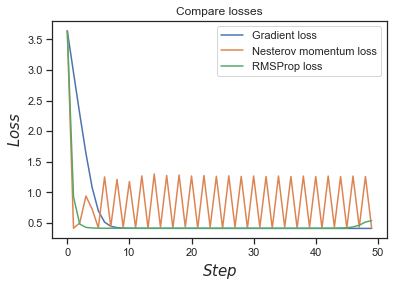

In [30]:
# Сравним скорость убывания ошибки
plt.plot(range(50), grad_loss_hist, label='Gradient loss' )
plt.plot(range(50), nest_loss_hist, label='Nesterov momentum loss' )
plt.plot(range(50), rmsp_loss_hist, label='RMSProp loss' )
plt.title('Compare losses')
plt.xlabel('$Step$', fontsize=15)
plt.ylabel('$Loss$', fontsize=15)
plt.legend()
plt.show()

**Вывод: лучший результат показал метод RMSProp. Nesterov momentum колеблется вокруг минимума**